In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# create dataloaders
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
train_loader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# store test data for faster inference (run on RTX 3090 with 24GB of VRAM)
test_label = []
test_img = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_label.append(y)
        test_img.append(x)
test_label = torch.hstack(test_label).to(device)
test_img = torch.vstack(test_img).to(device)
print(test_img.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 42.18it/s]


torch.Size([10000, 3, 32, 32])


In [4]:
data = torch.load(f"../../DD_data/0.pt")
synthetic_data = data["data"].cuda()
synthetic_label = data["label"].cuda()
data = torch.load(f"../../DD_data/1.pt")
synthetic_data2 = data["data"].cuda()
synthetic_label2 = data["label"].cuda()
data = torch.load(f"../../DD_data/2.pt")
synthetic_data3 = data["data"].cuda()
synthetic_label3 = data["label"].cuda()
data = torch.load(f"../../DD_data/3.pt")
synthetic_data4 = data["data"].cuda()
synthetic_label4 = data["label"].cuda()

In [ ]:
train_model = get_network("ConvNet", 3, 10, (32,32)).cuda()
optim = torch.optim.SGD(train_model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

syn_acc1 = []
syn_acc2 = []
syn_acc3 = []
syn_acc4 = []
syn_loss1 = []
syn_loss2 = []
syn_loss3 = []
syn_loss4 = []
test_acc = []
for _ in range(2):
    for i, (x,y) in tqdm(enumerate(train_loader)):
        train_model.train()
        x = x.cuda()
        y = y.cuda()
        loss = criterion(train_model(x)[-1], y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            test_acc.append(torch.sum(torch.argmax(train_model(test_img)[-1], dim=1) == test_label).item()/len(test_label))
            syn_acc1.append(torch.sum(torch.argmax(train_model(synthetic_data)[-1], dim=1) == synthetic_label).item()/len(synthetic_label))
            syn_acc2.append(torch.sum(torch.argmax(train_model(synthetic_data2)[-1], dim=1) == synthetic_label2).item()/len(synthetic_label2))
            syn_acc3.append(torch.sum(torch.argmax(train_model(synthetic_data3)[-1], dim=1) == synthetic_label3).item()/len(synthetic_label3))
            syn_acc4.append(torch.sum(torch.argmax(train_model(synthetic_data4)[-1], dim=1) == synthetic_label4).item()/len(synthetic_label4))
            syn_loss1.append(criterion(train_model(synthetic_data)[-1], synthetic_label).item())
            syn_loss2.append(criterion(train_model(synthetic_data2)[-1], synthetic_label2).item())
            syn_loss3.append(criterion(train_model(synthetic_data3)[-1], synthetic_label3).item())
            syn_loss4.append(criterion(train_model(synthetic_data4)[-1], synthetic_label4).item())

196it [00:24,  7.87it/s]
196it [00:24,  7.98it/s]


Text(0, 0.5, 'Accuracy')

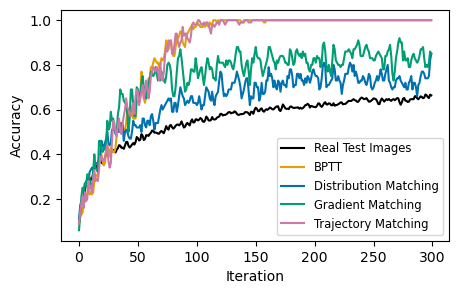

In [6]:
plt.figure(figsize=(5,3))
colours = ["#000000", "#E69F00", "#0072B2", "#009E73", "#CC79A7"]
plt.plot(test_acc[:300], label='Real Test Images',c=colours[0])
plt.plot(syn_acc1[:300], label='BPTT', c=colours[1])
plt.plot(syn_acc2[:300], label='Distribution Matching', c=colours[2])
plt.plot(syn_acc3[:300], label='Gradient Matching', c=colours[3])
plt.plot(syn_acc4[:300], label='Trajectory Matching', c=colours[4])
plt.legend(fontsize='small')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")